In [42]:
# Use Erdos_Spring_2025 conda env as created
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap


In [61]:
fname = 'data/dry_eye_disease_parsed.csv'
df0 = pd.read_csv(fname)

%run 'data/utils.py'
%run 'data/features_list.py'
%run 'data/model_params.py'

In [62]:
df = df0.copy()
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic',\
             'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
                 'combined_condition']
df = df.drop(columns=omit_cols)

['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'insomnia', 'combined_condition']


In [67]:
def feature_selection(df, col, best_params=None):
    target_col = col 
    y = df[target_col]
    #Drop the target columns, so the rest are feature columns
    X = df.drop(columns=target_col)
    
    # Splitting into training (80%) and testing (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    if best_params== None:
        # Define XGBoost model
        xgb_model = xgb.XGBClassifier(objective='reg:squarederror', random_state=42)

        param_grid = {
            'n_estimators': [50, 100, 200, 300, 500],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.7, 0.8, 1.0],
            'colsample_bytree': [0.7, 0.8, 1.0]
            #,'lambda': [1, 3, 5, 7, 9]
        }
        # Perform Grid Search
        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                                cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        
        # Get best parameters
        best_params = grid_search.best_params_
        
    print("Best Parameters:", best_params)
    
    # Train final model with best parameters
    best_xgb = xgb.XGBClassifier(**best_params, objective='reg:squarederror', random_state=42)
    best_xgb.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = best_xgb.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    print(f"Mean Squared Error: {mse * 100:.2f}%")
    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    print("-" * 30)
    
    # Feature Importance
    feature_names = X.columns.tolist()
    importance = best_xgb.feature_importances_
    f_pairs = list(zip(importance, feature_names))
    f_pairs.sort()
    importance_sort, feature_names_sort = zip(*f_pairs)
    
    # Assign color based on category
    bar_colors = [category_colors.get(feature_to_category.get(f, "Other"), "#7f7f7f") for f in feature_names_sort]
    
    # Format labels: capitalize and replace underscores/hyphens
    formatted_labels = [f.replace("_", " ").replace("-", " ").replace("/", " ").title()
        for f in feature_names_sort]

    max_imp = importance.max()
    print(max_imp)
    plt.figure(figsize=(10,6))
    plt.barh(list(feature_names_sort), list(importance_sort), color=bar_colors)
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title("XGBoost Feature Importance")
    plt.xscale('log')
    
    # Add legend
    legend_patches = [Patch(color=color, label=cat.replace("_", " ")) for cat, color in category_colors.items()]
    plt.legend(handles=legend_patches, title="Feature Categories", bbox_to_anchor=(1.05, 1), loc='upper left')


    plt.show()
    plt.clf()
    
    # # SHAP values for feature selection
    # explainer = shap.Explainer(best_xgb)
    # shap_values = explainer(X_train)
    # shap.summary_plot(shap_values, X_train, feature_names=feature_names)

Best Parameters: {'colsample_bytree': 0.7, 'lambda': 9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Mean Squared Error: 29.83%
Accuracy: 70.17%
Precision: 68.26%
Recall: 70.17%
F1 Score: 65.18%
------------------------------
0.25442243


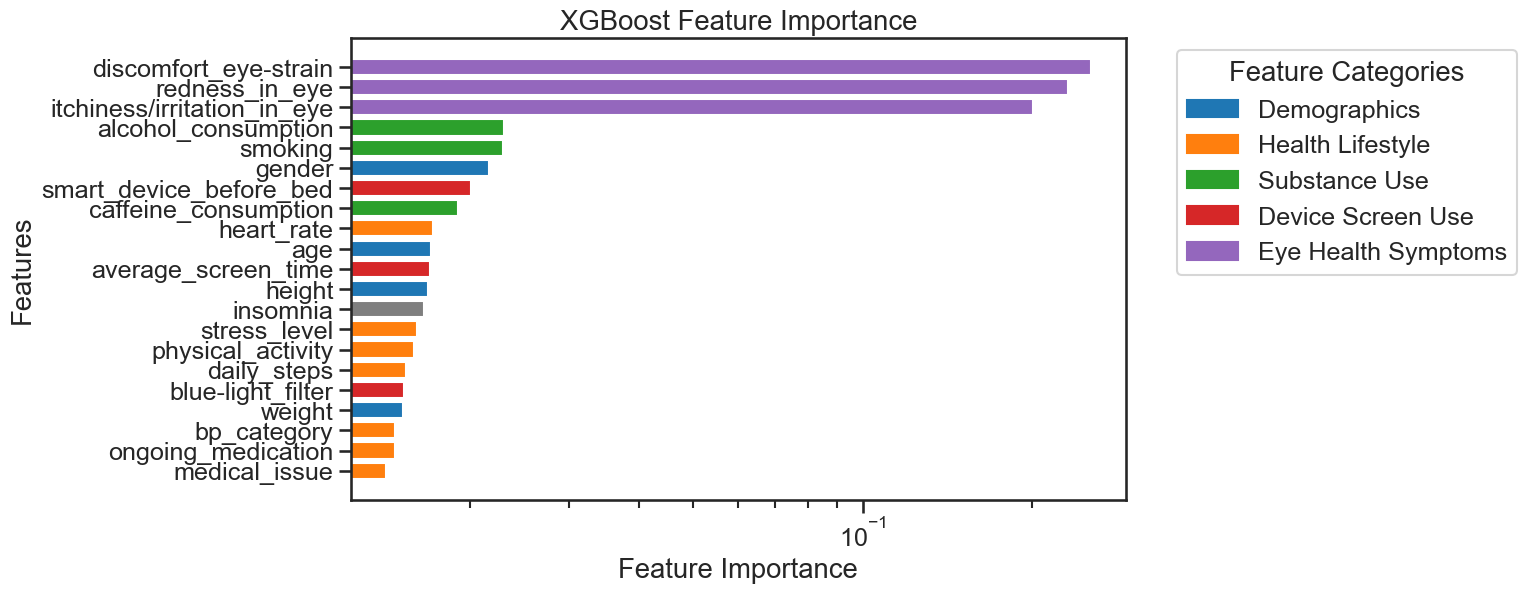

<Figure size 640x480 with 0 Axes>

In [64]:
feature_selection(df, 'dry_eye_disease', best_params=xgb_ded_full)

Best Parameters: {'colsample_bytree': 1.0, 'lambda': 9, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Mean Squared Error: 47.10%
Accuracy: 52.90%
Precision: 46.74%
Recall: 52.90%
F1 Score: 38.06%
------------------------------
0.056954823


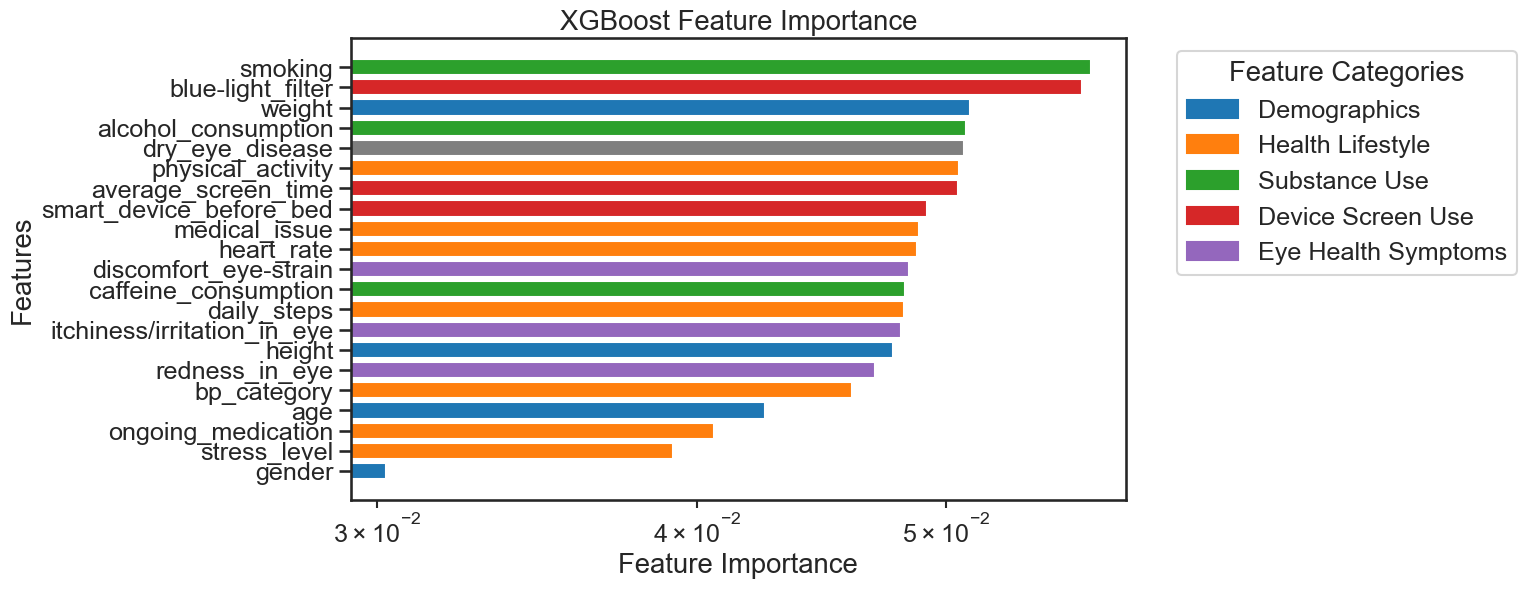

<Figure size 640x480 with 0 Axes>

In [65]:
feature_selection(df, 'insomnia', best_params=xgb_insomnia_full)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Mean Squared Error: 29.65%
Accuracy: 70.35%
Precision: 69.80%
Recall: 70.35%
F1 Score: 65.30%
------------------------------
0.33151174


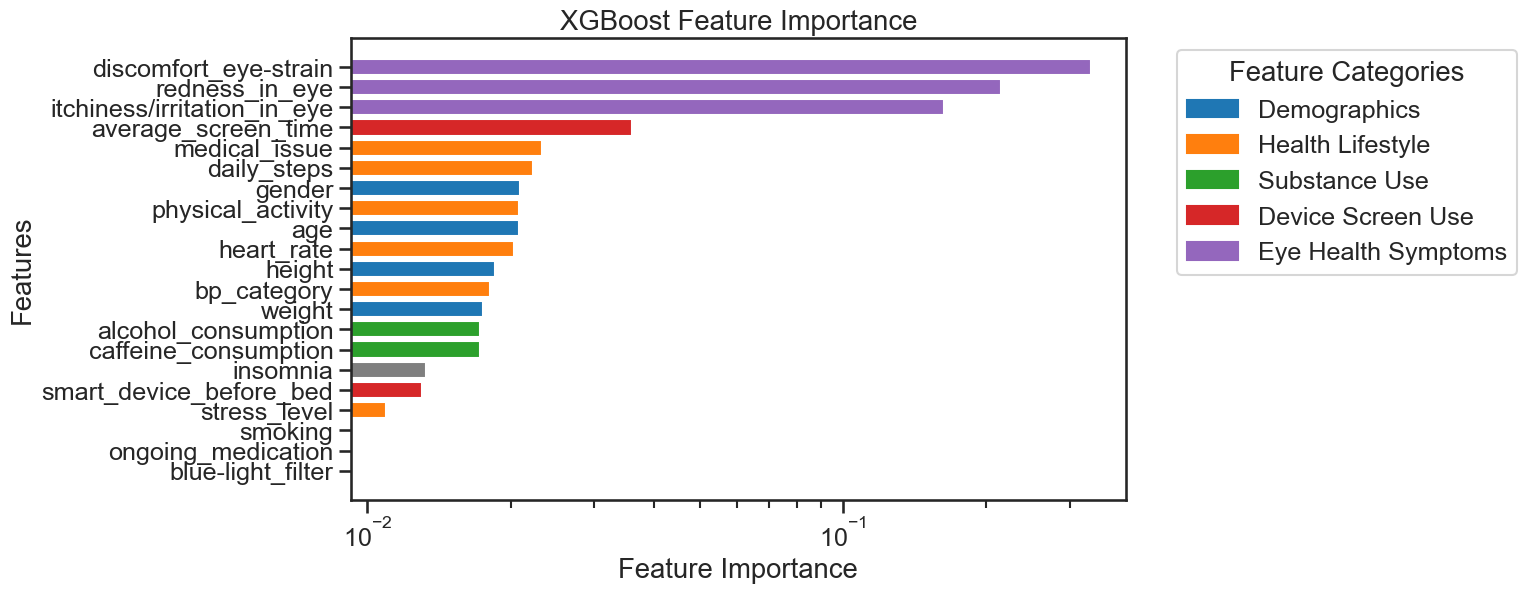

<Figure size 640x480 with 0 Axes>

In [ ]:
best_p = {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
feature_selection(df[df['age']<35], 'dry_eye_disease', best_params=best_p)

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: 29.76%
Accuracy: 70.24%
Precision: 70.36%
Recall: 70.24%
F1 Score: 65.49%
------------------------------
0.19581084


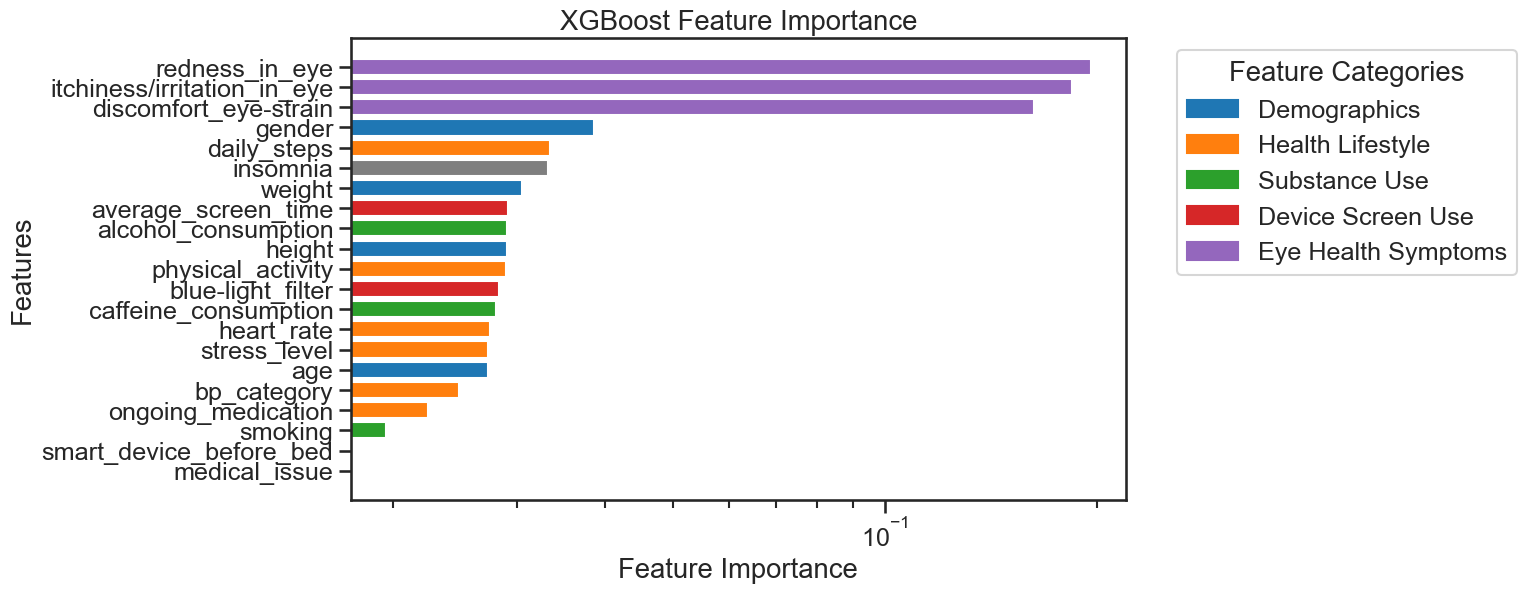

<Figure size 640x480 with 0 Axes>

In [70]:
best_p = {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
feature_selection(df[df['age']>=35], 'dry_eye_disease', best_params=best_p)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 31.43%
Accuracy: 68.57%
Precision: 67.82%
Recall: 68.57%
F1 Score: 63.33%
------------------------------
0.2144869


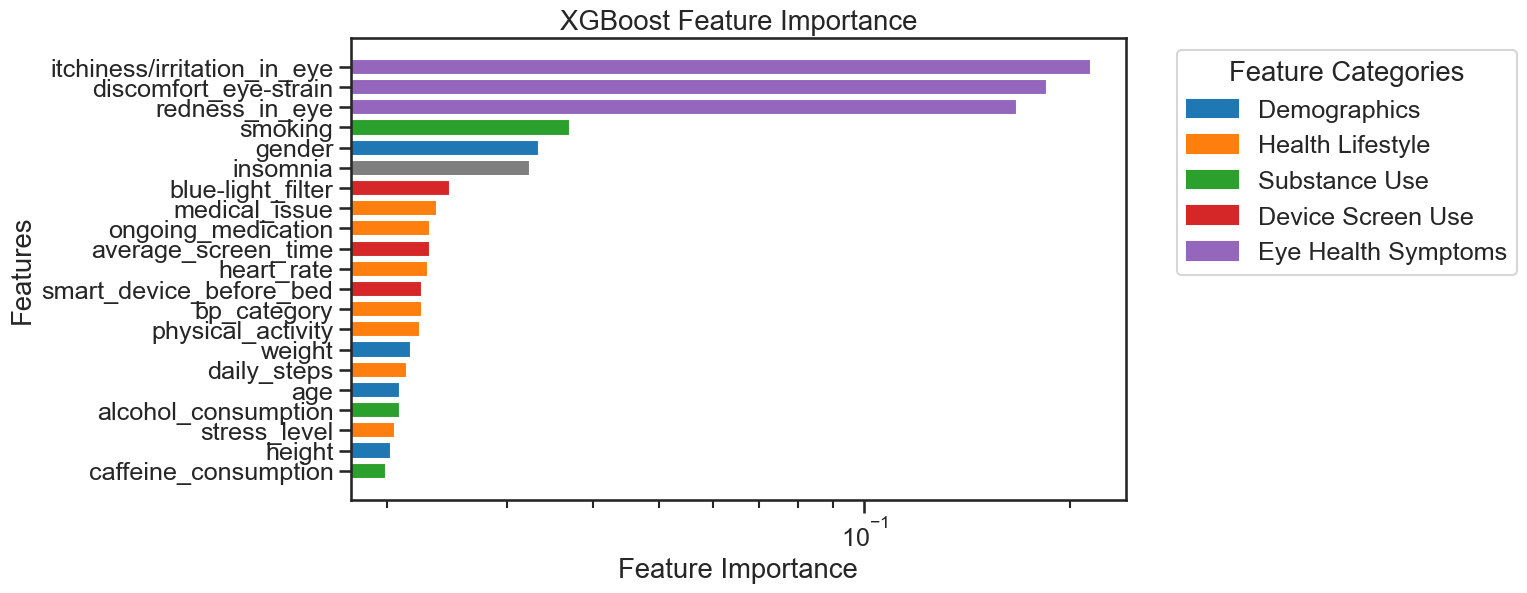

<Figure size 640x480 with 0 Axes>

In [ ]:
best_p = {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
feature_selection(df[df['physical_activity']<90], 'dry_eye_disease', best_params=best_p)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: 31.85%
Accuracy: 68.15%
Precision: 67.62%
Recall: 68.15%
F1 Score: 62.41%
------------------------------
0.2272668


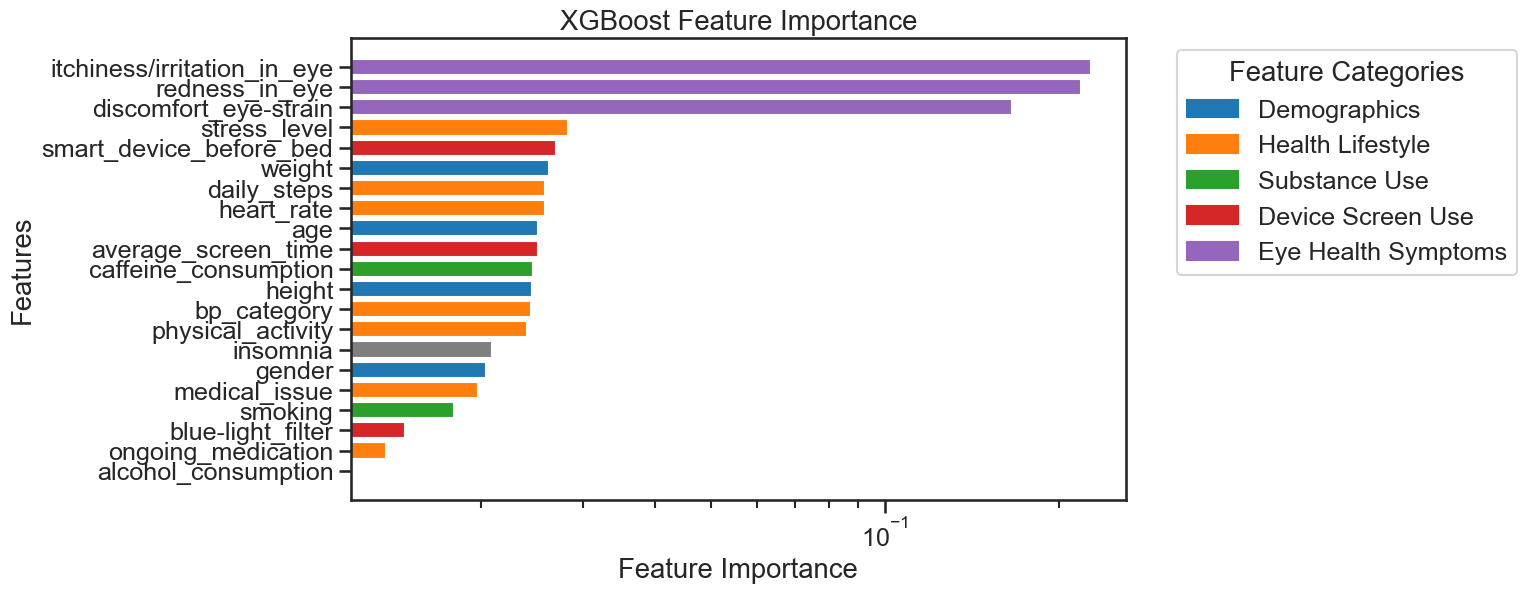

<Figure size 640x480 with 0 Axes>

In [73]:
best_p = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
feature_selection(df[df['physical_activity']>=90], 'dry_eye_disease', best_params=best_p)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Mean Squared Error: 31.70%
Accuracy: 68.30%
Precision: 69.20%
Recall: 68.30%
F1 Score: 63.63%
------------------------------
0.25346404


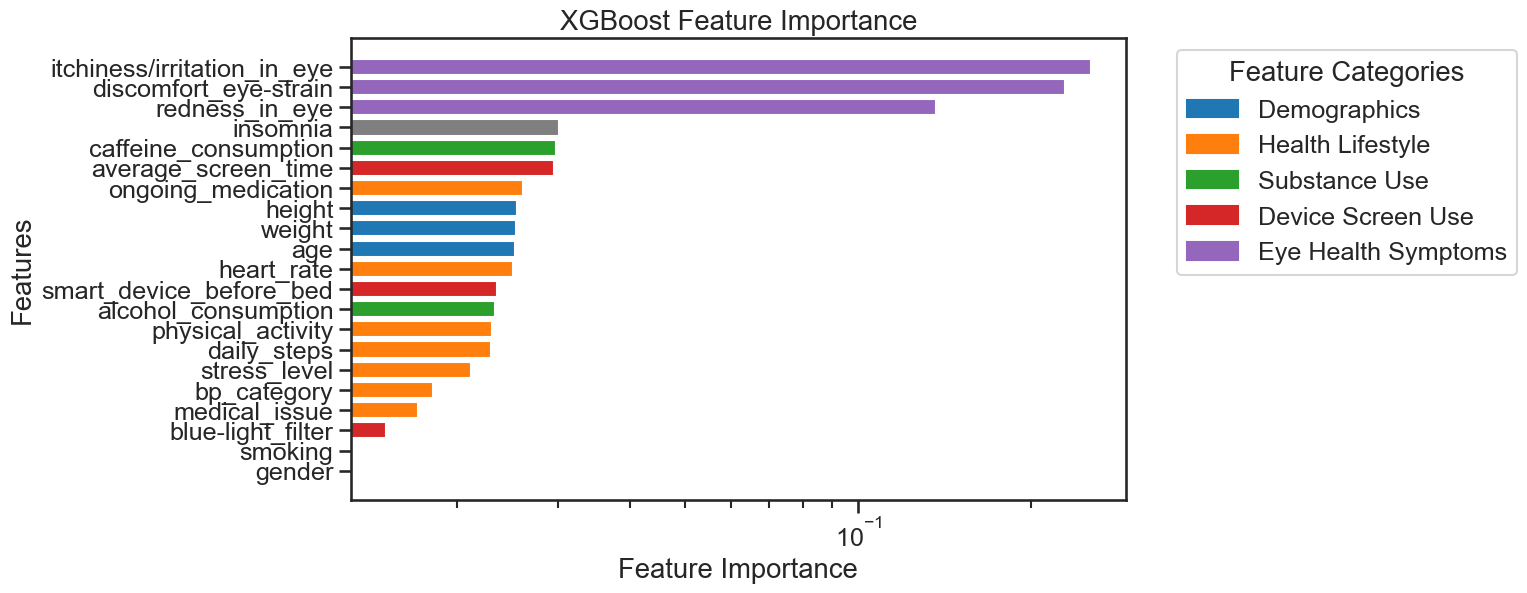

<Figure size 640x480 with 0 Axes>

In [ ]:
best_p = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
feature_selection(df[df['gender']==1], 'dry_eye_disease', best_params=best_p)

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Mean Squared Error: 30.13%
Accuracy: 69.87%
Precision: 69.33%
Recall: 69.87%
F1 Score: 65.02%
------------------------------
0.23520559


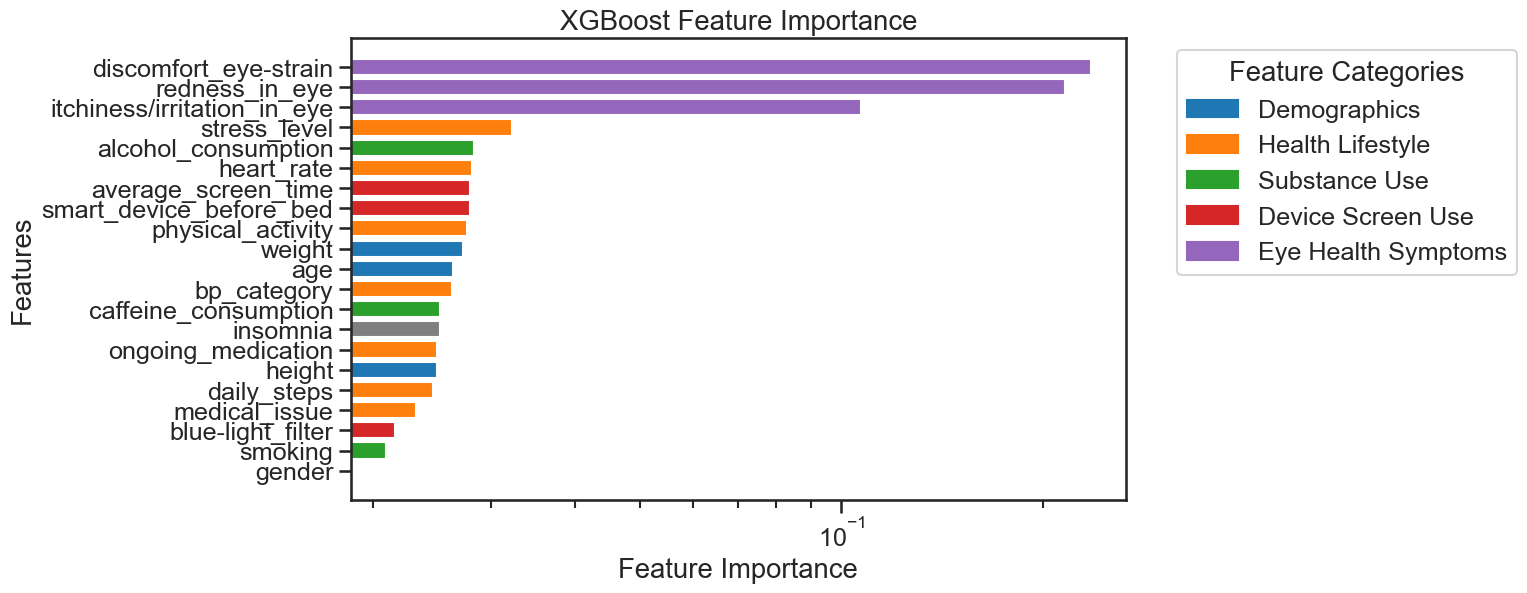

<Figure size 640x480 with 0 Axes>

In [ ]:
best_p = {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
feature_selection(df[df['gender']==0], 'dry_eye_disease', best_params=best_p)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 47.66%
Accuracy: 52.34%
Precision: 47.59%
Recall: 52.34%
F1 Score: 40.86%
------------------------------
0.05940618


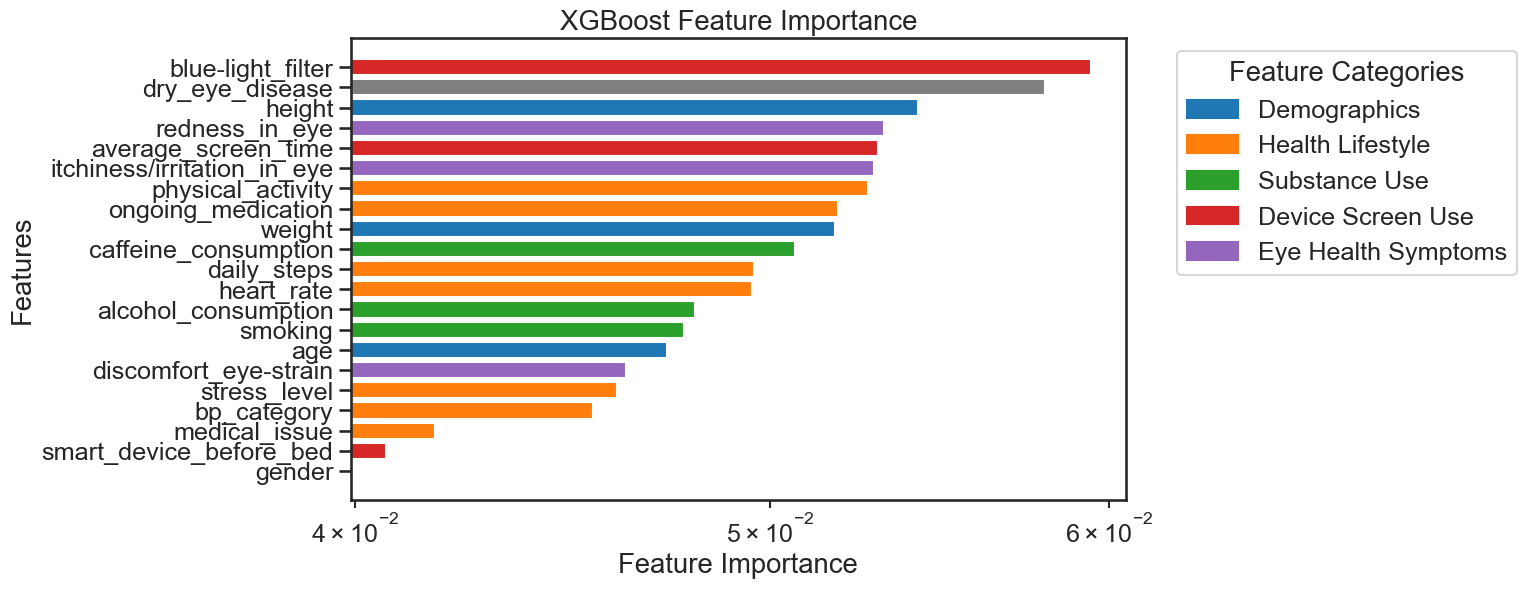

<Figure size 640x480 with 0 Axes>

In [76]:
feature_selection(df[df['gender']==1], 'insomnia', best_params=None)
